In [1]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile
import matplotlib.pyplot as plt

#Imports pour l'ACP
from sklearn.preprocessing import MinMaxScaler #pour normaliser entre 0 et 1
import seaborn as sns
from sklearn.decomposition import PCA

#Imports pour la modélisation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [2]:
url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Statistique desc

## Statut d'activité

In [45]:
#Catégories possibles
categories = ["Actif occupé", "Chômeur", "Inactif"]
value = [1,2,3] #on a aussi des NA mais ils ne sont pas pondérés
N=EEC_2019["EXTRIAN"].sum()

#Effectif par catégorie
result_dict = {"ACTEU": categories, 'Effectif': [], 'Proportion':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond = EEC_2019[EEC_2019["ACTEU"]==val]["EXTRIAN"].sum()
    result_dict['Effectif'].append(round(somme_pond,0))
    result_dict['Proportion'].append(round(somme_pond/N,3))
data = pd.DataFrame(result_dict).sort_values(by="ACTEU").reset_index(drop=True)
data

,ACTEU,Effectif,Proportion
0,Actif occupé,27176029.0,0.507
1,Chômeur,2506181.0,0.047
2,Inactif,23963417.0,0.447


## Durée du chômage

In [46]:
#répartiton de la durée de chômage avec la variable ANCCHOM (on pondère par EXTRIAN)
EEC_chom_2019=EEC_2019[EEC_2019["ACTEU"]==2]
EEC_chom_2020=EEC_2020[EEC_2020["ACTEU"]==2]
EEC_chom_2019["ANCCHOM"].describe()

count    18458.000000
mean         4.558024
std          2.187459
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max          8.000000
Name: ANCCHOM, dtype: float64

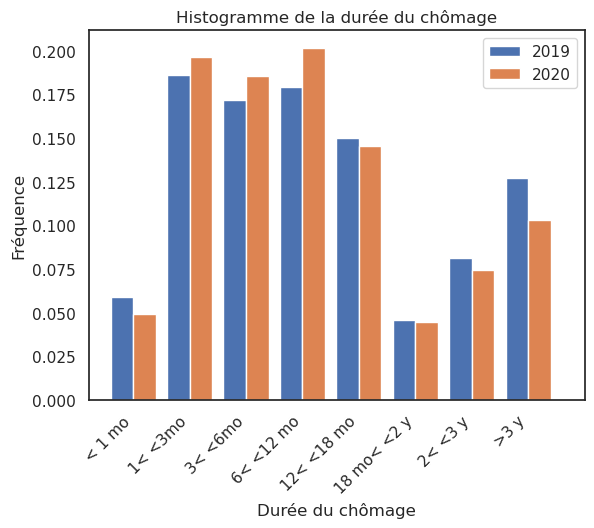

In [47]:
plt.hist([EEC_chom_2019["ANCCHOM"],EEC_chom_2020["ANCCHOM"]],bins=[i - 0.5 for i in range(1, 10)], weights = [EEC_chom_2019["EXTRIAN"],EEC_chom_2020["EXTRIAN"]], align='mid',width=0.4, density=True,label=["2019","2020"])
plt.title('Histogramme de la durée du chômage')
plt.xticks(range(1,10), ["< 1 mo","1< <3mo","3< <6mo","6< <12 mo","12< <18 mo","18 mo< <2 y","2< <3 y",">3 y",""], rotation=45, ha="right")
plt.xlabel('Durée du chômage')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

## CSP

In [48]:
#Catégories possibles
categories = ["Non-renseigné", "Agriculteurs", "Artisans, commerçants, chefs d'entreprise", "Cadres et professions intellectuelles supérieures", "Professions intermédiaires", "Employés", "Ouvriers", "Inactifs ayant déjà eu une activité pro", "Chômeurs et inactifs n'ayant jamais travaillé", "NA"]
value = EEC_2019["CSTOTR"].unique()

#tableau avec CSTOR/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"CSTOTR": value, 'Effectif_emploi': [], 'Effectif_chom':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CSTOTR"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CSTOTR"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
data = pd.DataFrame(result_dict).sort_values(by="CSTOTR").reset_index(drop=True)
data

,CSTOTR,Effectif_emploi,Effectif_chom
0,0.0,120715.0,12660.0
1,1.0,403572.0,4811.0
2,2.0,1825004.0,75003.0
3,3.0,5240635.0,191348.0
4,4.0,6957339.0,345401.0
5,5.0,7291505.0,737501.0
6,6.0,5337259.0,752857.0
7,7.0,0.0,0.0
8,8.0,0.0,386600.0
9,NaN,0.0,0.0


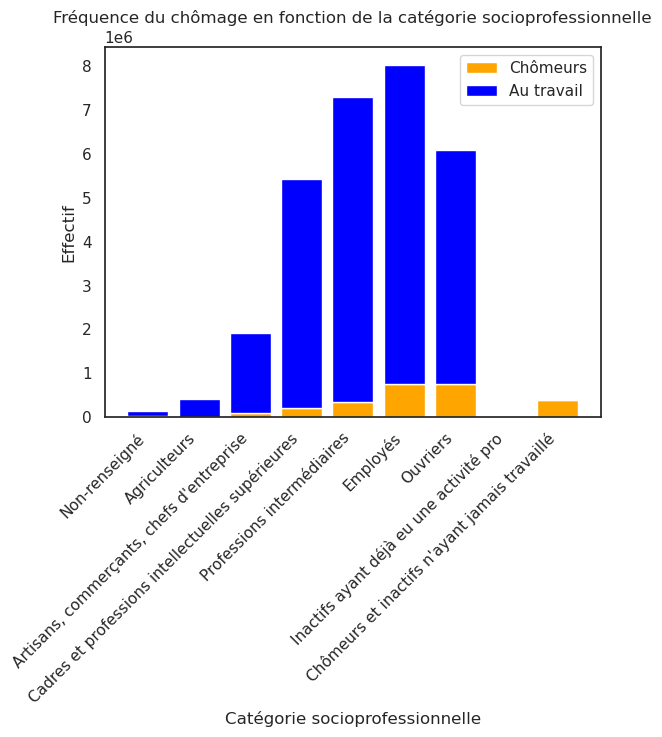

In [49]:
plt.bar(data["CSTOTR"],data["Effectif_chom"], color='orange', label='Chômeurs')
plt.bar(data["CSTOTR"],data["Effectif_emploi"], color='blue', label='Au travail', bottom=data["Effectif_chom"])
plt.title('Fréquence du chômage en fonction de la catégorie socioprofessionnelle')
plt.xlabel('Catégorie socioprofessionnelle')
plt.ylabel('Effectif')
plt.xticks(data["CSTOTR"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

## Age

In [50]:
#chômage par âge
#Catégories possibles
categories = ["15-29","30-39","40-49","50-59","60+",]
value = EEC_2019["AGE5"].unique()

#tableau avec AGE/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"AGE5": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["AGE5"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).sort_values(by="AGE5").reset_index(drop=True)
data

,AGE5,Effectif_emploi,Effectif_chom,Proportion_chom,Effectif_inac,Proportion_inac
0,15-29,1749306.0,121474.0,0.01,15015340.0,0.89
1,30-39,7118749.0,467806.0,0.05,936926.0,0.11
2,40-49,5072465.0,914344.0,0.08,5376700.0,0.47
3,50-59,6670976.0,441541.0,0.05,1610603.0,0.18
4,60+,6564533.0,561016.0,0.07,1023848.0,0.13


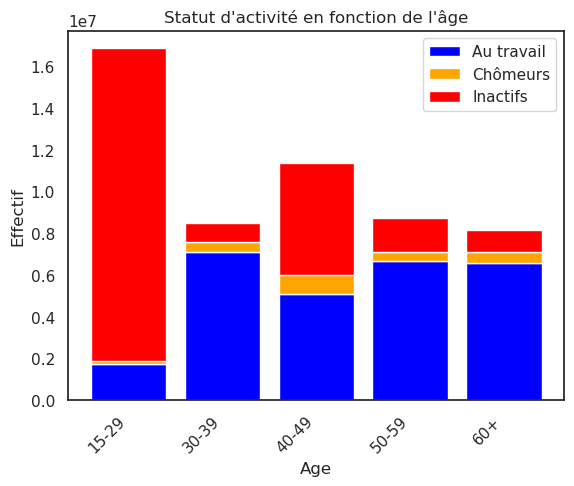

In [51]:
plt.bar(data["AGE5"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["AGE5"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["AGE5"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction de l'âge")
plt.xlabel('Age')
plt.ylabel('Effectif')
plt.xticks(data["AGE5"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

## Sexe

In [52]:
#chômage et inactivité par sexe
#Catégories possibles
categories = ["Homme","Femme"]
value = EEC_2019["SEXE"].unique()

#tableau avec SEXE/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"SEXE": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["SEXE"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).sort_values(by="SEXE").reset_index(drop=True)
data

,SEXE,Effectif_emploi,Effectif_chom,Proportion_chom,Effectif_inac,Proportion_inac
0,Femme,13991783.0,1300459.0,0.05,10321696.0,0.40
1,Homme,13184246.0,1205722.0,0.04,13641720.0,0.49


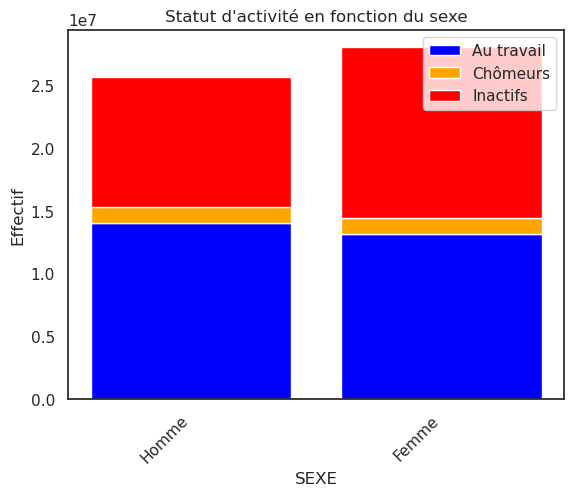

In [53]:
plt.bar(data["SEXE"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["SEXE"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["SEXE"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('SEXE')
plt.ylabel('Effectif')
plt.xticks(data["SEXE"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

## Catégorie de commune

In [54]:
#chômage et inactivité par taille de la commune
#Catégories possibles
categories = ["Grandes aires urbaines","Autres aires","Autres communes multipolarisées","Communes isolées hors influence des pôles"]
value = EEC_2019["CATAU2010R"].unique()

#tableau avec CAUTAU2010R/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"CATAU2010R": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CATAU2010R"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

,CATAU2010R,Effectif_emploi,Effectif_chom,Proportion_chom,Effectif_inac,Proportion_inac
0,Grandes aires urbaines,23126279.0,2146020.0,0.05,19554222.0,0.44
1,Autres aires,1059157.0,69715.0,0.03,1139339.0,0.50
2,Autres communes multipolarisées,1462749.0,106304.0,0.04,1379678.0,0.47
3,Communes isolées hors influence des pôles,1527845.0,184143.0,0.05,1890178.0,0.52


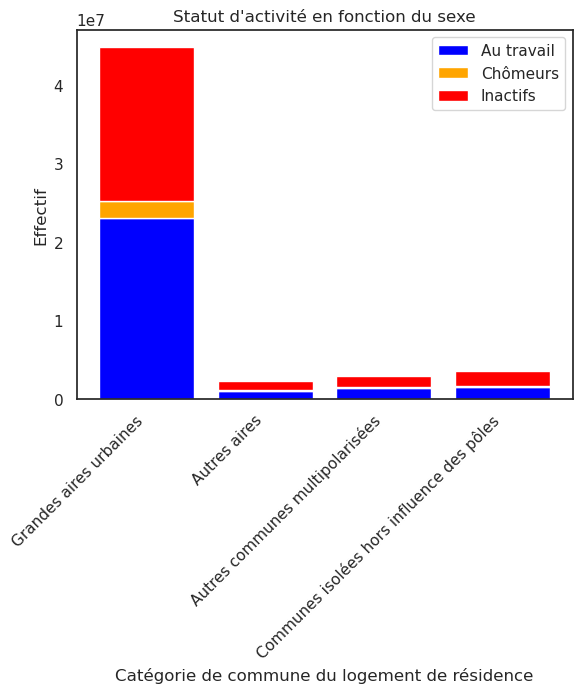

In [55]:
plt.bar(data["CATAU2010R"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["CATAU2010R"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["CATAU2010R"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('Catégorie de commune du logement de résidence')
plt.ylabel('Effectif')
plt.xticks(data["CATAU2010R"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

# Analyse en composantes principales

## Normalisation

Variables à inclure dans la matrice de variance-covariance : ACTEU, SEXE,DIP11, type de ménages, CSTOTR, NFRRED,NBTOTE (heures travaillées usuellement) HPLUSA (nombre d'heures voulues), implication dans la recherche (CONTACT,DEM),accepterait temps partiel, ANCCHOM, AGE5, CATAU2010R ruralité, COURED ENFRED couple

Variables à transformer en indicatrices (attention ne pas mettre toutes les catégories) : ACTEU DIP11, CSTOTR, NFRRED, AGE5, CATAU2010R + plus variables à régler en 0,1

Variables à normaliser : NBTOTE, HPLUSA, ANNCHOM (mettre unité)

In [56]:
#Création d'une base PCA
EEC_PCA=EEC_2019
EEC_PCA=pd.DataFrame(EEC_PCA[["EXTRIAN","ACTEU","SEXE","DIP11","CSTOTR","NFRRED","NBTOTE","HPLUSA","HHCE","CONTACT",
"ANCCHOM","AGE5","AIDFAM","CATAU2010R","COURED","ENFRED"]]).reset_index(drop=True)
EEC_PCA

,EXTRIAN,ACTEU,SEXE,DIP11,CSTOTR,NFRRED,NBTOTE,HPLUSA,HHCE,CONTACT,ANCCHOM,AGE5,AIDFAM,CATAU2010R,COURED,ENFRED
0,107.749722,3.0,2,70.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,60,NaN,1,2,2
1,46.173848,1.0,1,50.0,6.0,1.0,NaN,NaN,1.0,NaN,NaN,60,NaN,1,1,2
2,46.173848,3.0,2,70.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,60,2.0,1,1,2
3,44.329298,1.0,1,50.0,6.0,1.0,NaN,NaN,1.0,NaN,NaN,60,NaN,1,1,2
4,44.329298,3.0,2,70.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,60,2.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416293,29.855074,3.0,1,42.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,60,2.0,1,2,2
416294,32.789031,3.0,1,42.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,60,2.0,1,2,2
416295,24.988029,3.0,2,71.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,60,2.0,1,2,2
416296,22.399182,3.0,2,71.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,60,2.0,1,2,2


In [57]:
#ACTEU
EEC_PCA["CHOM"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==2, "CHOM"]=1

EEC_PCA["INAC"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==3, "INAC"]=1

In [58]:
#DIP11 que l'on va séparer en indicatrices pour enseignement sup, secondaire et en dessous
EEC_PCA["infcollege"]=0 #infcollege = aucun diplome, certif d'études, brevet
EEC_PCA.loc[EEC_PCA["DIP11"].isin([71,70,60]), "infcollege"]=1

EEC_PCA["secondaireplus"]=0 #secondaire plus = secondaire + BTS et DUT...
EEC_PCA.loc[EEC_PCA["DIP11"].isin([50,42,41,33,31]), "secondaireplus"]=1

EEC_PCA["sup"]=0 #le reste
EEC_PCA.loc[EEC_PCA["DIP11"].isin([30,11,10]), "sup"]=1

In [59]:
#SEXE (0 = H, 1 = F)
EEC_PCA.loc[EEC_PCA["SEXE"]==1, "SEXE_bin"]=0
EEC_PCA.loc[EEC_PCA["SEXE"]==2, "SEXE_bin"]=1

In [60]:
#CSTOTR : en se basant sur le graphique ci-dessus, je crée une catégorie employé avec les professions intermédiaires, les employés et les ouvriers
#et je crée une catégorie employeur avec les cadres sups, artisans, chef d'entreprises
EEC_PCA["employe"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([4,5,6]), "employe"]=1

EEC_PCA["employeur"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([2,3]), "employeur"]=1
#on a 3/4 de l'échantillon employe et 1/4 employeur

In [61]:
#NFRRED : variable indicatrice : "l'individu est-il de nationalité française ?"
EEC_PCA["NAT"]=0
EEC_PCA.loc[EEC_PCA["NFRRED"].isin([1,2]), "NAT"]=1
#1/20 sans nationalité FR

In [62]:
#AGE5 : transformer en deux indicatrices jeunes actifs (0 à 29 ans) ou actifs âgés (plus de 50 ans)
EEC_PCA["JEUNE"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([00,15]), "JEUNE"]=1

EEC_PCA["ANCIEN"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([50,60]), "ANCIEN"]=1
#1/5 de jeunes et 1/3 d'anciens

In [63]:
#CONTACT : contact avec pôle emploi depuis dernière enquête (3 mois), 1 si oui
EEC_PCA["P_E"]=0
EEC_PCA.loc[EEC_PCA["CONTACT"]==1, "P_E"]=1
#moins d'1/20

In [64]:
#création de metrop. 1 si l'individu habite dans un grande aire urbaine : 4/5 échantillon
EEC_PCA["METROP"]=0
EEC_PCA.loc[EEC_PCA["CATAU2010R"]==1, "METROP"]=1

In [65]:
#COURED : 1 si l'individu est en couple
EEC_PCA["COUPLE"]=0
EEC_PCA.loc[EEC_PCA["COURED"]==1, "COUPLE"]=1
#2/3 en couple

In [66]:
#ENFRED : 1 si l'individu a un enfant
EEC_PCA["ENF"]=0
EEC_PCA.loc[EEC_PCA["ENFRED"]==1, "ENF"]=1
#la moitié a un enfant

In [70]:
#NBTOTE
col = EEC_PCA['NBTOTE']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['NBTOTE'] = colonne_normalisee
EEC_PCA["NBTOTE"].describe()
#très peu d'entrées dans cette variable (à remédier)

count    9462.000000
mean        0.629828
std         0.230385
min         0.000000
25%         0.495798
50%         0.647059
75%         0.781513
max         1.000000
Name: NBTOTE, dtype: float64

In [71]:
#HPLUSA (beaucoup d'informations manquantes, surtout les personnes ne voulant pas modifier leur charge horraire, on va donc prendre 
#leur charge horraire actuelle comme souhait.
EEC_PCA["HHCE"]=EEC_PCA["HHCE"].fillna(0)
EEC_PCA.loc[EEC_PCA['HPLUSA'].isna(), "HPLUSA"]=EEC_PCA[EEC_PCA['HPLUSA'].isna()]["HHCE"]

In [72]:
col = EEC_PCA['HPLUSA']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['HPLUSA'] = colonne_normalisee
EEC_PCA["HPLUSA"].describe()

count    416298.000000
mean          0.174642
std           0.201204
min           0.000000
25%           0.000000
50%           0.000000
75%           0.361809
max           1.000000
Name: HPLUSA, dtype: float64

In [73]:
#ANCCHOM : recodage en mois
EEC_PCA["ANCCH"]=0.0#en emploi
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==1, "ANCCH"]=1.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==2, "ANCCH"]=2.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==3, "ANCCH"]=4.5
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==4, "ANCCH"]=9.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==5, "ANCCH"]=15.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==6, "ANCCH"]=21.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==7, "ANCCH"]=30.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==8, "ANCCH"]=40.0
EEC_PCA["ANCCH"].describe()

count    416298.000000
mean          0.680171
std           4.274341
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: ANCCH, dtype: float64

In [74]:
col = EEC_PCA['ANCCH']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['ANCCH'] = colonne_normalisee
EEC_PCA["ANCCH"].describe()

count    416298.000000
mean          0.017004
std           0.106859
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ANCCH, dtype: float64

## Matrice de covariances

In [75]:
EEC_PCA1=EEC_PCA[['HPLUSA', 'CHOM','INAC', 'infcollege', 'P_E',"ANCCH",
       'secondaireplus', 'sup', 'SEXE_bin', 'employe', 'employeur', 'NAT',
       'JEUNE', 'ANCIEN', 'METROP', 'COUPLE', 'ENF']] #on omet NBTOTE pas assez d'ind.
noms_var=EEC_PCA1.columns
EEC_PCAW=EEC_PCA["EXTRIAN"].to_numpy()
EEC_PCA1.head()

,HPLUSA,CHOM,INAC,infcollege,P_E,ANCCH,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,METROP,COUPLE,ENF
0,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,1,0,0
1,0.01005,0,0,0,0,0.0,1,0,0.0,1,0,1,0,1,1,1,0
2,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,1,1,0
3,0.01005,0,0,0,0,0.0,1,0,0.0,1,0,1,0,1,1,1,0
4,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,1,1,0


In [76]:
EEC_COV_NP=np.cov(EEC_PCA1.to_numpy(), rowvar=False, aweights=EEC_PCAW)
EEC_COV=pd.DataFrame(EEC_COV_NP) #matrice de covariance pondérée
EEC_COV.columns = noms_var #on affiche le nom des variables correspondantes en x et y
EEC_COV.set_index(EEC_COV.columns, inplace=True)
EEC_COV

,HPLUSA,CHOM,INAC,infcollege,P_E,ANCCH,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,METROP,COUPLE,ENF
HPLUSA,0.041428,-0.008964,-0.085715,-0.031662,-0.002925,-0.003011,0.013564,0.017932,-0.013064,0.054870,0.029508,0.001684,-0.006544,-0.032863,0.002920,0.018821,0.034300
CHOM,-0.008964,0.044535,-0.020869,-0.000803,0.012456,0.014957,0.002101,-0.001355,-0.001936,0.015565,-0.001420,-0.002415,0.007148,-0.011807,0.000966,-0.007126,0.001146
INAC,-0.085715,-0.020869,0.247160,0.079704,-0.005615,-0.007009,-0.038920,-0.040319,0.020878,-0.178377,-0.061053,-0.000551,0.005604,0.096678,-0.008756,-0.037614,-0.087091
infcollege,-0.031662,-0.000803,0.079704,0.208357,-0.000811,0.000647,-0.150956,-0.056733,0.008364,-0.046182,-0.032312,-0.013112,0.003213,0.041956,-0.009851,-0.028624,-0.032177
P_E,-0.002925,0.012456,-0.005615,-0.000811,0.026948,0.004723,0.002093,-0.001358,-0.000013,0.005873,-0.001267,-0.001316,0.001312,-0.005720,-0.000012,-0.002581,0.002626
ANCCH,-0.003011,0.014957,-0.007009,0.000647,0.004723,0.009866,0.000281,-0.000941,-0.000745,0.005101,-0.000570,-0.000973,0.000714,-0.002454,0.000276,-0.002567,0.000701
secondaireplus,0.013564,0.002101,-0.038920,-0.150956,0.002093,0.000281,0.249899,-0.097790,-0.010525,0.060223,-0.022868,0.013658,-0.001734,-0.016560,-0.005361,0.014673,0.018450
sup,0.017932,-0.001355,-0.040319,-0.056733,-0.001358,-0.000941,-0.097790,0.154956,0.002329,-0.013622,0.055321,-0.000477,-0.002097,-0.024736,0.014976,0.014304,0.013745
SEXE_bin,-0.013064,-0.001936,0.020878,0.008364,-0.000013,-0.000745,-0.010525,0.002329,0.249493,-0.000091,-0.018542,-0.000008,-0.004576,0.007778,0.001049,-0.013818,0.012492
employe,0.054870,0.015565,-0.178377,-0.046182,0.005873,0.005101,0.060223,-0.013622,-0.000091,0.239865,-0.054577,-0.000556,0.004219,-0.076915,0.002042,0.019490,0.061240


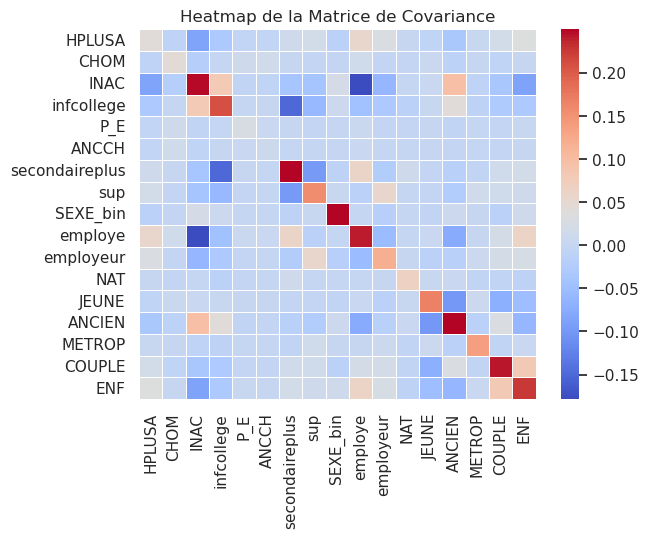

In [77]:
# Utiliser seaborn pour créer la heatmap
sns.set(style="white")
sns.heatmap(EEC_COV, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Afficher la heatmap
plt.title('Heatmap de la Matrice de Covariance')
plt.show()

## PCA

In [78]:
# Appliquer la PCA
pca = PCA()
composantes_principales = pca.fit(EEC_COV).components_

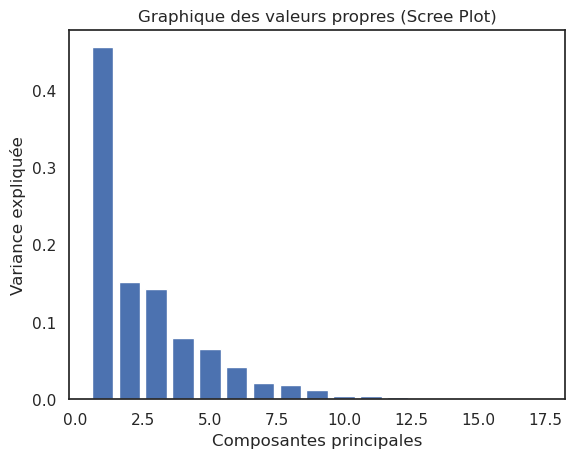

In [79]:
# Graphique des valeurs propres
valeurs_propres = pca.explained_variance_ratio_
plt.bar(range(1, len(valeurs_propres) + 1), valeurs_propres)
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Graphique des valeurs propres (Scree Plot)')
plt.show()

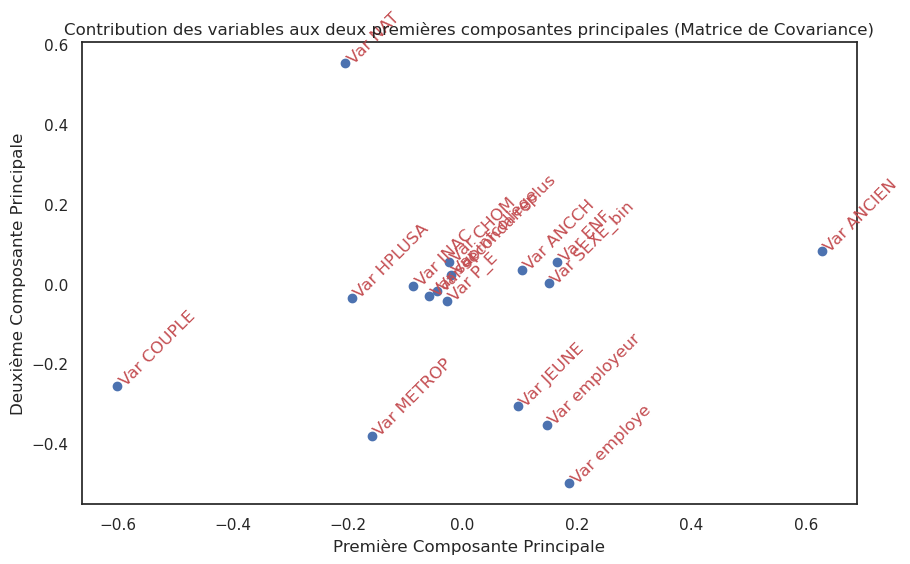

In [80]:
# Sélectionner les deux premiers vecteurs propres
first_pc = composantes_principales[:, 0]
second_pc = composantes_principales[:, 1]
variable_names = EEC_COV.columns.tolist()

# Tracer le graphique de dispersion des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(first_pc, second_pc)

# Annoter chaque point avec le nom de la variable
for i, variable in enumerate(variable_names):
    plt.annotate(f'Var {variable}', (first_pc[i], second_pc[i]), color='r', rotation=45)

# Ajouter des labels et un titre au graphique
plt.title('Contribution des variables aux deux premières composantes principales (Matrice de Covariance)')
plt.xlabel('Première Composante Principale')
plt.ylabel('Deuxième Composante Principale')

# Afficher le graphique
plt.show()

# Modélisation

## Partie I: Preparation des données (preprocessing)

In [3]:
# On choisit un ensemble de variables qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié et qui sont disponibles sur les deux années étudiées

# Notre variable d'intérêt ici est ACTEU

# Variables à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ;
# DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# Pour la prise en compte de la PCS, il n'est pas possible d'utiliser CSTOT /  CSTOTPRM / CSTOTR
# Ce sont des variables qui distinguent les actifs des non-actifs
# Possibilité de recoder à partir de CSP et CSA

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSA" ,"CSP" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected] 

list_var = list(EEC_2019.columns.values)
print(list_var)

['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'CSA', 'CSP', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']


### Recodage d'une variable de PCS à deux niveaux regroupant actifs occupés et les autres

In [4]:
#On commence par vérifier que les variables CSP (actifs occupés) et CSA (non actifs occupés) ne sont pas renseignées pour les mêmes individus

non_nan_csp = EEC_2019['CSP'].notna()
non_nan_csa = EEC_2019['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

Les variables ne sont pas renseignées pour les mêmes individus


In [5]:
#On peut donc sommer les deux colonnes pour obtenir la valeur voulue
EEC_2019['PCS'] = EEC_2019['CSA'].add(EEC_2019['CSP'], fill_value=0)

pcs_manquante = EEC_2019['PCS'].isna().sum()

print(pcs_manquante)
#1260 valeurs manquantes, donc assez peu

1260


In [6]:
#Idem pour EEC_2020
#Création d'une variable de PCS avec la PCS des actifs occupés et l'ancienne des inactifs et chômeurs.
non_nan_csp = EEC_2020['CSP'].notna()
non_nan_csa = EEC_2020['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

#On peut donc sommer les deux colonnes
EEC_2020['PCS'] = EEC_2020['CSA'].add(EEC_2020['CSP'], fill_value=0)

pcs_manquante = EEC_2020['PCS'].isna().sum()

print(pcs_manquante)
#864 valeurs manquantes, donc très peu

Les variables ne sont pas renseignées pour les mêmes individus
864


In [8]:
#Attention, notre variable 'PCS' contient une modalité en 2019,qui n'existe pas en 2020
#Cela vient de la modalité "10" de la PCS ("agriculteur") qui n'existe pas pour 2020, et uniquement chez des non actifs occupés
#On peut supposer qu'il s'agit d'agriculteurs pour lesquels la taille d'exploitation n'a pu être déterminée...
#Cela ne concerne que deux observations
EEC_2019['PCS'].value_counts()[0]
print(EEC_2019.shape)
#Lors de la conversion de la variable en indicatrice, nous allons donc obtenir des bases de tailles différentes
#pour éviter cela, on décide de supprimer ces deux observations
EEC_2019 = EEC_2019[EEC_2019['PCS'] != 10]
print(EEC_2019.shape)

(416298, 16)
(416296, 16)


In [9]:
#On enlève de la base les variables CSA et CSP
EEC_2019 = EEC_2019.drop(['CSA', 'CSP'], axis=1)
EEC_2020 = EEC_2020.drop(['CSA', 'CSP'], axis=1)

### Analyses des NA de notre base

In [10]:
#Comptons le nombre de NaN dans nos df
nombre_lignes_nan_2019 = EEC_2019.isnull().any(axis=1).sum()
nombre_lignes_nan_2020 = EEC_2020.isnull().any(axis=1).sum()
print(nombre_lignes_nan_2019)
print(nombre_lignes_nan_2020)

4205
3379


In [11]:
#Isolons nos observations avec des NAN
EEC_2019_with_nulls = EEC_2019[EEC_2019.isna().any(axis=1)]
EEC_2020_with_nulls = EEC_2020[EEC_2020.isna().any(axis=1)]

In [12]:
print(EEC_2019_with_nulls.shape)
print(EEC_2020_with_nulls.shape)

(4205, 14)
(3379, 14)


In [13]:
EEC_2019_with_nulls = EEC_2019_with_nulls.copy()
EEC_2019_with_nulls['total_nan'] = EEC_2019_with_nulls.isna().sum(axis=1)

In [14]:
print(EEC_2019_with_nulls['total_nan'].mean())
#En moyenne, 1,79 valeurs manquantes, sur 14 variables

1.7938168846611178


In [15]:
#On affiche un tableau avec le nombre de NAN par variable, et le pourcentage des observations manquantes que cela représente
nan_count_variable_2019 = EEC_2019_with_nulls.isna().sum()
print(nan_count_variable_2019)
nan_percentage_variable_2019 = (EEC_2019_with_nulls.isna().sum() / len(EEC_2019_with_nulls)) * 100
print(nan_percentage_variable_2019)
#A chaque fois il nous manque donc le diplôme, et dans environ un tiers des cas la PCS recodée et la variable d'intérêt, un cinquième des nationalités

ACTEU         1260
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         4205
ENFRED           0
METRODOM         0
NFRRED         818
SEXE             0
TYPMEN7          0
PCS           1260
total_nan        0
dtype: int64
ACTEU          29.964328
ANNEE           0.000000
TRIM            0.000000
AGE3            0.000000
AGE5            0.000000
CATAU2010R      0.000000
COURED          0.000000
DIP11         100.000000
ENFRED          0.000000
METRODOM        0.000000
NFRRED         19.453032
SEXE            0.000000
TYPMEN7         0.000000
PCS            29.964328
total_nan       0.000000
dtype: float64


In [16]:
#Même chose pour 2020
EEC_2020_with_nulls = EEC_2020_with_nulls.copy()
EEC_2020_with_nulls['total_nan'] = EEC_2020_with_nulls.isna().sum(axis=1)
print(EEC_2020_with_nulls['total_nan'].mean())
#En moyenne, 1,67 valeurs manquantes, sur 14 variables
nan_count_variable_2020 = EEC_2020_with_nulls.isna().sum()
print(nan_count_variable_2020)
nan_percentage_variable_2020 = (EEC_2020_with_nulls.isna().sum() / len(EEC_2020_with_nulls)) * 100
print(nan_percentage_variable_2020)
#On retrouve des choses très semblables sur 2020, avec encore une fois surtout le diplôme qui manque

1.6738680082864752
ACTEU          864
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         3377
ENFRED           0
METRODOM         0
NFRRED         551
SEXE             0
TYPMEN7          0
PCS            864
total_nan        0
dtype: int64
ACTEU         25.569695
ANNEE          0.000000
TRIM           0.000000
AGE3           0.000000
AGE5           0.000000
CATAU2010R     0.000000
COURED         0.000000
DIP11         99.940811
ENFRED         0.000000
METRODOM       0.000000
NFRRED        16.306600
SEXE           0.000000
TYPMEN7        0.000000
PCS           25.569695
total_nan      0.000000
dtype: float64


In [17]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2019_with_nulls_non_ACTEU = EEC_2019_with_nulls.dropna(subset=['ACTEU'])
EEC_2019_with_nulls_non_ACTEU = EEC_2019_with_nulls_non_ACTEU.copy()
EEC_2019_with_nulls_non_ACTEU['total_nan'] = EEC_2019_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2019_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2019_non_ACTEU = EEC_2019_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2019_non_ACTEU)
nan_percentage_variable_2019_non_ACTEU = (EEC_2019_with_nulls_non_ACTEU.isna().sum() / len(EEC_2019_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2019_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

1.0122241086587436
ACTEU            0
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         2945
ENFRED           0
METRODOM         0
NFRRED          36
SEXE             0
TYPMEN7          0
PCS              0
total_nan        0
dtype: int64
ACTEU           0.000000
ANNEE           0.000000
TRIM            0.000000
AGE3            0.000000
AGE5            0.000000
CATAU2010R      0.000000
COURED          0.000000
DIP11         100.000000
ENFRED          0.000000
METRODOM        0.000000
NFRRED          1.222411
SEXE            0.000000
TYPMEN7         0.000000
PCS             0.000000
total_nan       0.000000
dtype: float64


In [18]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2020_with_nulls_non_ACTEU = EEC_2020_with_nulls.dropna(subset=['ACTEU'])
EEC_2020_with_nulls_non_ACTEU = EEC_2020_with_nulls_non_ACTEU.copy()
EEC_2020_with_nulls_non_ACTEU['total_nan'] = EEC_2020_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2020_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2020_non_ACTEU = EEC_2020_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2020_non_ACTEU)
nan_percentage_variable_2020_non_ACTEU = (EEC_2020_with_nulls_non_ACTEU.isna().sum() / len(EEC_2020_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2020_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

1.0127236580516898
ACTEU            0
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         2515
ENFRED           0
METRODOM         0
NFRRED          32
SEXE             0
TYPMEN7          0
PCS              0
total_nan        0
dtype: int64
ACTEU           0.000000
ANNEE           0.000000
TRIM            0.000000
AGE3            0.000000
AGE5            0.000000
CATAU2010R      0.000000
COURED          0.000000
DIP11         100.000000
ENFRED          0.000000
METRODOM        0.000000
NFRRED          1.272366
SEXE            0.000000
TYPMEN7         0.000000
PCS             0.000000
total_nan       0.000000
dtype: float64


In [19]:
# Il y a très peu de valeurs manquantes dans les variables, 4205 variables concernées en 2019, 3379 en 2020.
#Si on supprime d'office les observations pour lesquelles manquent la variable d'intérêt, on tombe à 2945 et 2515, et c'est systématiquement le diplôme qui manque
#On choisit donc de les supprimer de la base pour le moment
print(EEC_2019.shape)
print(EEC_2020.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)
print(EEC_2020.shape)

(416296, 14)
(319398, 14)
(412091, 14)
(316019, 14)


### Suite et fin du préprocessing

In [20]:
# Conversion de l'ensemble des variables catégorielles en indicatrices
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS", "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS" , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE des variables binaires

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)

EEC_2019['ACTIF'] = EEC_2019['ACTEU'].apply(lambda x: (x == 1) or (x == 2))
EEC_2020['ACTIF'] = EEC_2020['ACTEU'].apply(lambda x: (x == 1) or (x == 2))

EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#On retire les variables non recodées
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

# 73 variables
print(EEC_2019.shape)
print(EEC_2020.shape)

(412091, 73)
(316019, 73)


#### Création de notre sous-ensemble, et de nos array pour sklearn

In [19]:
#Pour rendre les calculs plus rapide, on se concentre sur un sous-ensemble
EEC_2019_subsample = EEC_2019.sample(n=10000, random_state=3) 

In [20]:
# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

EMPLOI
False    0.5344
True     0.4656
Name: proportion, dtype: float64


In [21]:
# Description d'une feature pour check booléen
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

count     10000
unique        2
top        True
freq       5291
Name: FEMME, dtype: object


In [22]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
print(X.shape)

# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])
print(y.shape)

(10000, 70)
(10000,)


In [26]:
#création de nos ensemble de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=4)

## Partie II : Support Vector Machine

Nous essayons ici d'appliquer un modèle de type SVM pour prédire la situation d'emploi à partir des variables socio-démographiques, en essayant de sélectionner le paramètre régularisation qui permet la meilleure précision sur notre (sous)-échantillon de test.

In [24]:
acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param, random_state=3)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))

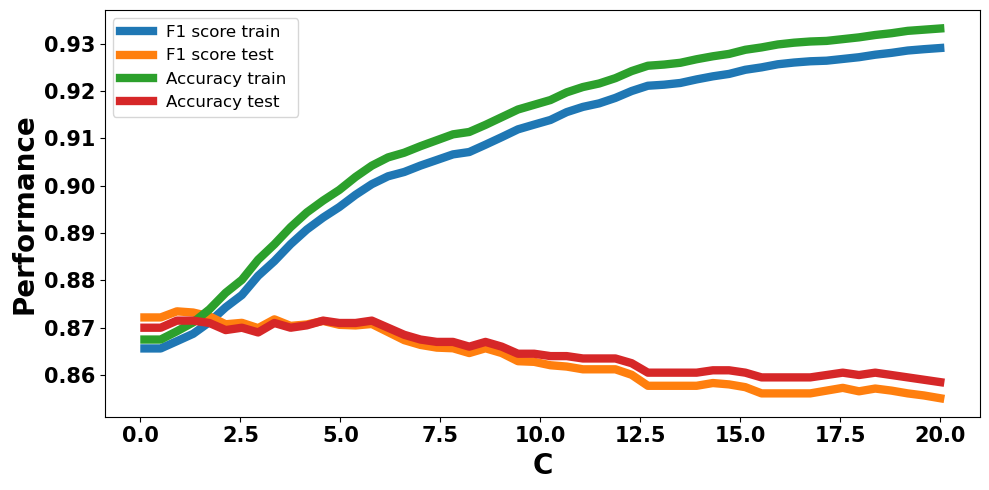

In [25]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

Il semble ici que très vite la performance diminue sur le test, dès des valeurs assez petites du paramètre C, ce qui indique que le modèle de SVM rentre très vite dans une phase de surapprentissage : on s'attends à ce que notre modèle ne sélectionne qu'un nomre limité de variables.

In [26]:
#utilisation de GridSearch pour trouver le meilleur paramètre de régularisation
params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=SVC( C=params, random_state=3), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

#Calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 2.857571428571428}
0.883125
0.8695


Comme attendu, GridSearch nous propose donc un paramètre de régularisation faible, autours de 2,85, avec un score de 0,896, signifiant que 89,6% de nos observations du test sont correctement prédites.

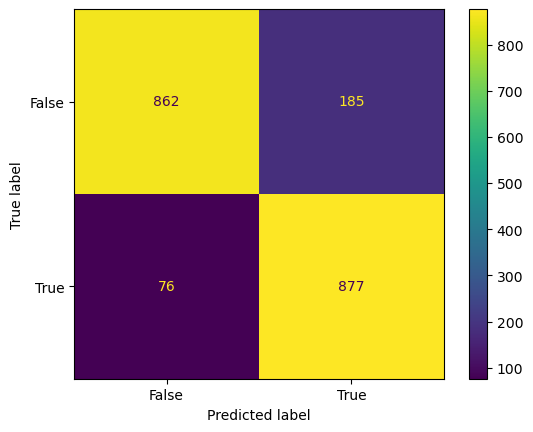

In [27]:
clf = SVC( C=gs.best_params_['C'], random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

## Partie III - Regression logistique

Nous essayons ici une autre méthode, à savoir la régression logistique

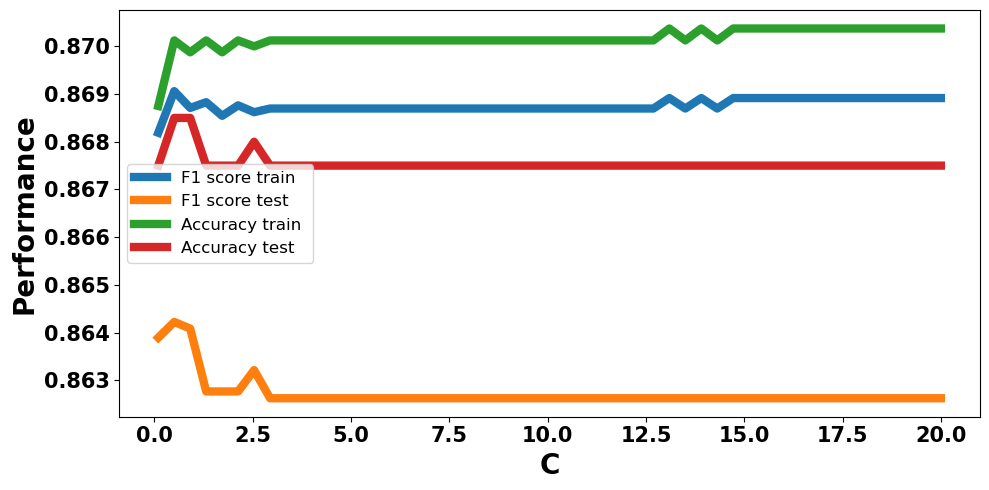

In [27]:
acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

                        
C_range = np.linspace(0.1, 20, 50)

for param in C_range:
    clf = LogisticRegression(C=param,random_state=3, penalty="l1",solver='liblinear' )
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

#TOUJOURS GRAPH UN PEU BIZARRE -> PQ PERFORMANCE MEILLEURE SUR TEST QUE SUR TRAIN??? 
#Ce problème disparait dès lors que l'on se place avec uneautre répartition train/test (j'ai changé la seed)
# Pas de diminution de la performance quand regularisation diminue?

In [28]:
# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
# ATTENTION -> gain de selection des paramètres via cross validation est marginal par rapport à la selection des bonnes variables 
# On utilise GridSearch ici parce qu'on veut combiner plusieurs paramètres

#  By default, scikit-learn's GridSearchCV does not select the most parsimonious model (fewer features)
# when multiple models have equal scores. GridSearchCV uses the mean cross-validated score to select
# the best model based on the specified scoring metric.
# If there are multiple models with the same highest mean score, GridSearchCV selects
# the one with the smallest value of the parameters.

# If we want to select the most parsimonious model among those with equal scores,
# you may need to implement a custom scoring function

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

                       params  mean_test_score  std_test_score
0                {'C': 0.001}         0.532125        0.000306
1   {'C': 0.1030204081632653}         0.868625        0.012590
2   {'C': 0.2050408163265306}         0.868375        0.012091
3   {'C': 0.3070612244897959}         0.868375        0.012347
4   {'C': 0.4090816326530612}         0.868250        0.012102
5   {'C': 0.5111020408163265}         0.868000        0.011901
6   {'C': 0.6131224489795918}         0.867750        0.012181
7   {'C': 0.7151428571428571}         0.867750        0.012721
8   {'C': 0.8171632653061224}         0.867750        0.012647
9   {'C': 0.9191836734693877}         0.867875        0.012491
10  {'C': 1.0212040816326529}         0.867875        0.012714
11   {'C': 1.123224489795918}         0.867625        0.012256
12  {'C': 1.2252448979591835}         0.867750        0.012328
13  {'C': 1.3272653061224489}         0.867875        0.012460
14   {'C': 1.429285714285714}         0.867625        0

In [29]:
# On refait meme process en jouant en + sur le critère de penalty et le tol
# tol = tolerance for stopping criteria. It defines the stopping criterion for the solver to converge to a solution.

params= { 'C':np.linspace(0.001, 5, 50),'tol': [0.01, 0.1, 1, 10] }


gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 1.0212040816326529, 'tol': 0.1}
0.86975
0.865


Le modèle choisit atteint une précision de l'ordre de 86,5% sur le test, ce qui est légérement moins efficace que le modèle SVMde la partie précédente

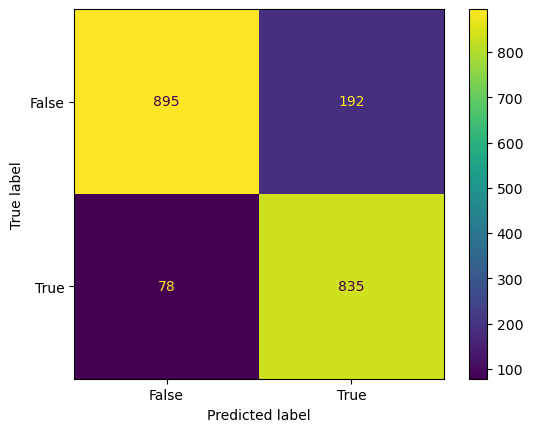

In [30]:
clf = LogisticRegression( tol=gs.best_params_['tol'], C=gs.best_params_['C'], random_state=3,
                         penalty ="l1", solver='liblinear')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [31]:
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)
#Conserve la grande majorité des variables

Number of variables considered: 67


## Partie IV : Selections de variables

In [32]:
#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

# X transform contient un nombre réduit de caractéristiques basé sur la sélection
# des caractéristiques par régression Lasso
sfm.fit(X,y)
X_transform = sfm.transform(X)
print("Transformed data shape:", X_transform.shape)
print("Original data shape:", X.shape)

Transformed data shape: (10000, 10)
Original data shape: (10000, 70)


In [35]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=4)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }



gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

#Perd un peu en performance avec 10 variables max

{'C': 0.5310816326530613, 'tol': 0.01}
0.869125
0.8655


Number of variables considered: 10


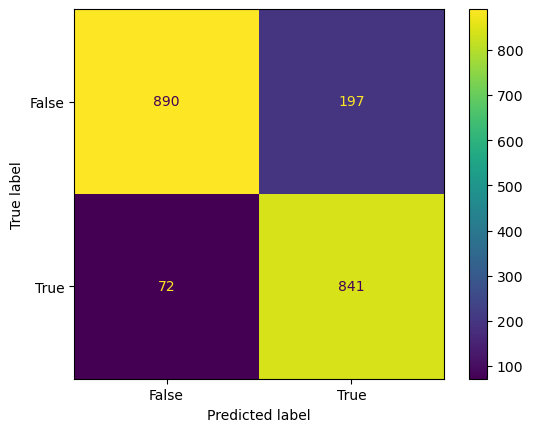

In [36]:
clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

In [37]:
#Identify the indices of the variables used for prediction in X_transform
variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]

X_transform_useful_variables = X_transform[:,variables_indices]

# X_transform n'a pas les meme indices pour les colonnes que X ou EEC_2019 -> Je verifie quelle colonne a les meme 
# valeurs
for j in range(X_transform_useful_variables.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_useful_variables[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column  is equal to the {column_name} column in EEC_2019_subsample")

The 1 column  is equal to the AGE5_60 column in EEC_2019_subsample
The 2 column  is equal to the PCS_0.0 column in EEC_2019_subsample
The 3 column  is equal to the PCS_12.0 column in EEC_2019_subsample
The 4 column  is equal to the PCS_13.0 column in EEC_2019_subsample
The 5 column  is equal to the PCS_55.0 column in EEC_2019_subsample
The 6 column  is equal to the PCS_67.0 column in EEC_2019_subsample
The 7 column  is equal to the DIP11_10.0 column in EEC_2019_subsample
The 8 column  is equal to the DIP11_11.0 column in EEC_2019_subsample
The 9 column  is equal to the TYPMEN7_6 column in EEC_2019_subsample
The 10 column  is equal to the COUPLE column in EEC_2019_subsample


In [38]:
# J'essaie de reconstruire la variable predite à partir des variables et des coefs associés
linear_pred_3 = clf.intercept_ + np.dot(X_test_2[:, variables_indices], clf.coef_[:, variables_indices].T) 
y_pred_3 = 1 / (1 + np.exp(-linear_pred_3))
threshold = 0.5  
y_pred_3_binary = (y_pred_3 > threshold).astype(bool).ravel()

comparison = np.equal(y_pred_2, y_pred_3_binary)
equal_predictions = np.sum(comparison)
percentage_equal = (equal_predictions / len(y_pred_2)) * 100 
print("% same predictor",percentage_equal)

% same predictor 100.0


## Partie V : Compréhension du problème de prédiction

Nous pensons que les problèmes de prédiction proviennent des chômeurs de courte durée qui ont donc des caractéristiques très similaires aux actifs de ma base, et sont donc prédits comme tels. Pour vérifier cela, je vais maintenant étudier la prédiction du fait d'être actif pour voir si nous parvenons à construire un meilleur prédicteur.



In [39]:
# Array contentant la variable expliquée
y_bis = np.array(EEC_2019_subsample["ACTIF"])
print(y_bis.shape)

print(y_bis[:10])

(10000,)
[ True False False  True False  True  True  True  True False]


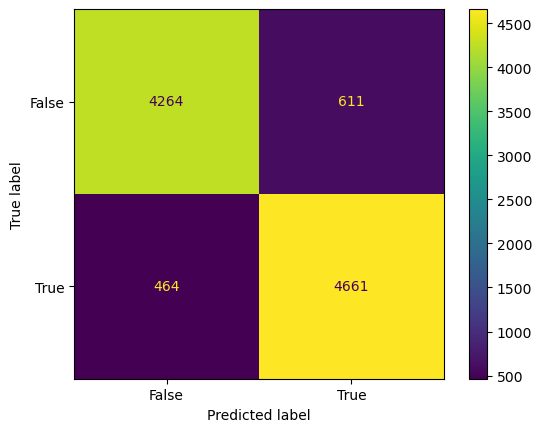

In [40]:
y_pred = clf.predict(X_transform)

cm= confusion_matrix(y_bis,y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

# Prédicteur de l'emploi déjà très bon pour prédire actif/pas actif => logique

(10000, 10)
[[-3.52988977 -3.40453955  0.          0.          0.          0.57974758
   0.          0.          0.         -0.14053532]]
Number of variables considered: 4


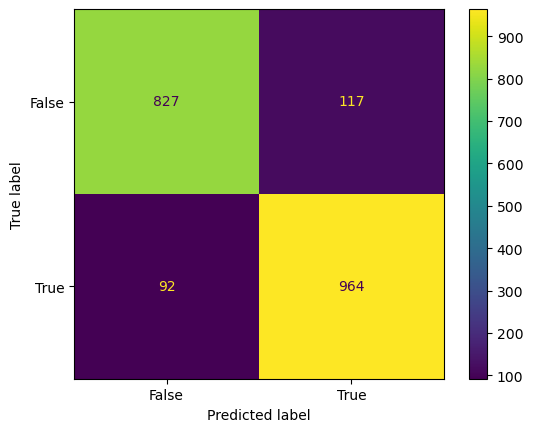

In [41]:
#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y_bis)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

sfm.fit(X,y_bis)

X_transform_bis = sfm.transform(X)
print(X_transform_bis.shape)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform_bis, 
                                                    y_bis, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }

gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

print(clf.coef_)
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

In [42]:
#=> ON dirait que les indices des colonnes change lorsqu'on passe de X à X_transform
# => ['AGE3_15' 'AGE3_30' 'AGE3_50'] ne sont pas les "bonnes" variables
# Iterate over a range of columns in X_transform_bis
for j in range(X_transform_bis.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_bis[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column in X_transform_bis is equal to the {column_name} column in EEC_2019_subsample")

The 1 column in X_transform_bis is equal to the AGE5_60 column in EEC_2019_subsample
The 2 column in X_transform_bis is equal to the PCS_0.0 column in EEC_2019_subsample
The 3 column in X_transform_bis is equal to the PCS_12.0 column in EEC_2019_subsample
The 4 column in X_transform_bis is equal to the PCS_13.0 column in EEC_2019_subsample
The 5 column in X_transform_bis is equal to the PCS_31.0 column in EEC_2019_subsample
The 6 column in X_transform_bis is equal to the DIP11_10.0 column in EEC_2019_subsample
The 7 column in X_transform_bis is equal to the DIP11_11.0 column in EEC_2019_subsample
The 8 column in X_transform_bis is equal to the DIP11_60.0 column in EEC_2019_subsample
The 9 column in X_transform_bis is equal to the TYPMEN7_6 column in EEC_2019_subsample
The 10 column in X_transform_bis is equal to the ENFANT column in EEC_2019_subsample


Il semblerait que le problème vienne effectivement de la distinction qui peut être parfois difficile à faire entre les chomeurs et les actifs occupés puisque les résultats s'améliorent grandement

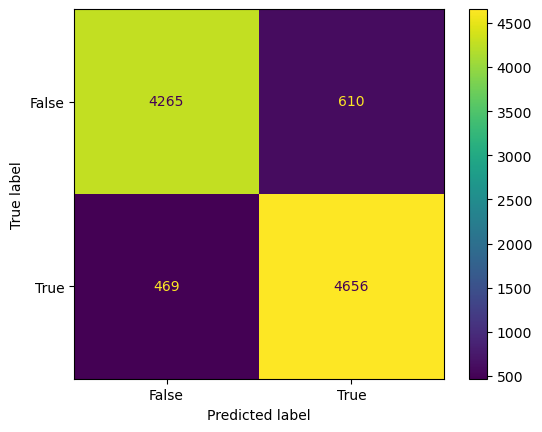

In [43]:
y_pred_4 = clf.predict(X_transform_bis)

cm= confusion_matrix(y_bis,y_pred_4)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [44]:
X_2020 = np.array(EEC_2020.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
y_2020 = np.array(EEC_2020["ACTIF"])

X_2020_transform = sfm.transform(X_2020)
print(X_2020_transform.shape)

y_pred_2020 = clf.predict(X_2020_transform)


cm= confusion_matrix(y_2020,y_pred_2020)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

ValueError: X has 69 features, but SelectFromModel is expecting 70 features as input.